# Phân cụm khách hàng bằng DBSCAN
Trong notebook này, ta sẽ áp dụng thuật toán **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**  
để phân cụm dữ liệu khách hàng từ bộ dữ liệu `Wholesale_customers_data.csv`.

Các bước thực hiện:
1. Đọc và phân tích dữ liệu.
2. Tiền xử lý, chuẩn hóa và giảm chiều dữ liệu.
3. Chạy thuật toán DBSCAN.
4. Đánh giá và trực quan hóa kết quả.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

# Đọc dữ liệu
df = pd.read_csv("Wholesale_customers_data.csv")
print("Kích thước dữ liệu:", df.shape)
df.head()

Kích thước dữ liệu: (440, 8)


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


### 1. Phân tích dữ liệu ban đầu
Ta xem thông tin cơ bản của bộ dữ liệu, kiểm tra giá trị thiếu và phân bố từng thuộc tính.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


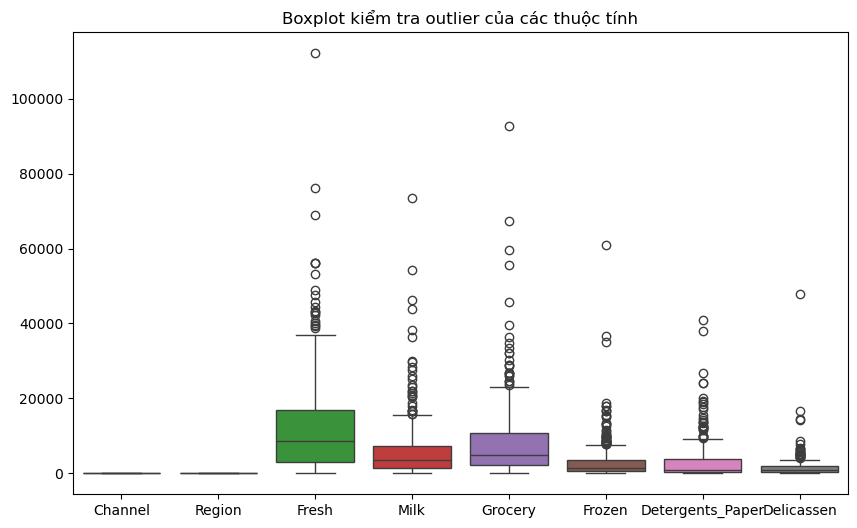

In [27]:
df.info()
df.describe()

# Biểu đồ hộp kiểm tra outlier
plt.figure(figsize=(10,6))
sns.boxplot(data=df)
plt.title("Boxplot kiểm tra outlier của các thuộc tính")
plt.show()

### 2. Tiền xử lý dữ liệu
Dữ liệu `Wholesale customers` có phân bố lệch nên ta áp dụng log-transform để giảm skewness,  
sau đó chuẩn hóa dữ liệu bằng `StandardScaler` để cân bằng thang đo giữa các thuộc tính.


In [28]:
# Log-transform để giảm skewness (độ lệch)
X_log = np.log1p(df)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

print("Dữ liệu sau chuẩn hóa có dạng:", X_scaled.shape)


Dữ liệu sau chuẩn hóa có dạng: (440, 8)


### 3. Giảm chiều dữ liệu bằng PCA (2D)
Để DBSCAN hoạt động ổn định và dễ trực quan hóa,  
ta giảm dữ liệu từ 6 đặc trưng xuống **2 thành phần chính** bằng **PCA**.  
Việc này giúp:
- Loại bỏ nhiễu.
- Dễ hình dung cụm trong không gian hai chiều.
- Tăng tốc độ tính toán cho DBSCAN.

In [29]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_scaled)

print("Tỷ lệ phương sai giữ lại:", np.sum(pca.explained_variance_ratio_))
print("Dạng dữ liệu sau PCA:", X_reduced.shape)


Tỷ lệ phương sai giữ lại: 0.6133687671322205
Dạng dữ liệu sau PCA: (440, 2)


### 4. Xác định giá trị epsilon (ε) tối ưu cho DBSCAN

DBSCAN có hai tham số chính:

- **eps (ε)**: bán kính lân cận mà trong đó các điểm được xem là “hàng xóm”.
- **min_samples**: số lượng điểm tối thiểu cần có trong vùng lân cận để tạo thành một cụm.

Việc chọn ε quá **nhỏ** sẽ khiến dữ liệu bị chia nhỏ thành quá nhiều cụm hoặc nhiều điểm bị xem là nhiễu.  
Ngược lại, ε quá **lớn** sẽ khiến các cụm bị dính lại thành một khối lớn, làm mất ý nghĩa phân cụm.

Một cách phổ biến để chọn ε là **vẽ đồ thị khoảng cách k-láng giềng gần nhất** (k thường = `min_samples`).  
Ta tìm **điểm gấp khúc (elbow)** trên đồ thị — đó chính là giá trị ε tốt nhất,  
vì sau điểm này, khoảng cách tăng nhanh → tức là vượt ra khỏi ranh giới cụm.


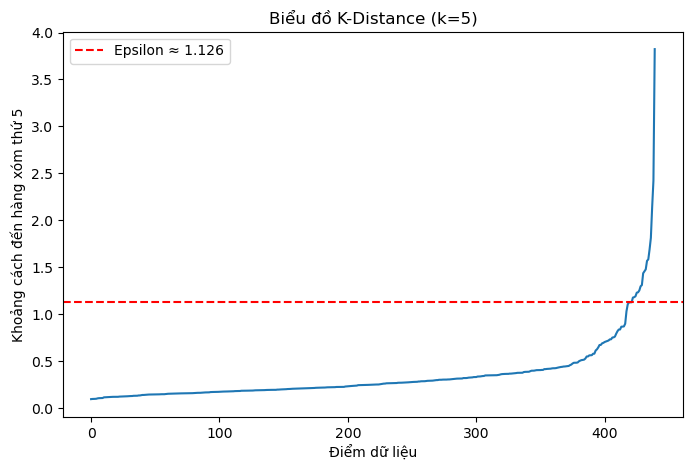

Giá trị epsilon gợi ý (theo Elbow Method): 1.126


In [30]:
from kneed import KneeLocator

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_reduced)
distances, indices = neighbors_fit.kneighbors(X_reduced)
distances = np.sort(distances[:,4])

plt.figure(figsize=(8,5))
plt.plot(distances)
plt.title("Biểu đồ K-Distance (k=5)")
plt.xlabel("Điểm dữ liệu")
plt.ylabel("Khoảng cách đến hàng xóm thứ 5")
# 🔹 Xác định "knee" (điểm gấp khúc) → epsilon
kneedle = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')
epsilon = distances[kneedle.knee] if kneedle.knee is not None else None

# Vẽ đường thẳng tại epsilon (nếu tìm thấy)
if epsilon is not None:
    plt.axhline(y=epsilon, color='r', linestyle='--', label=f"Epsilon ≈ {epsilon:.3f}")
    plt.legend()

plt.show()

# 📢 In ra giá trị epsilon
if epsilon is not None:
    print(f"Giá trị epsilon gợi ý (theo Elbow Method): {epsilon:.3f}")
else:
    print("Không tìm thấy điểm gấp khúc rõ ràng trong biểu đồ.")

### 5. Chạy DBSCAN trên dữ liệu PCA 2D
Sau khi chọn giá trị `eps` tại điểm “gối” của biểu đồ k-distance,  
ta huấn luyện DBSCAN và xem số cụm được phát hiện.

In [48]:
# 🔹 Các giá trị cần thử
eps_values = np.arange(0.2, 2.8, 0.2)
min_samples_values = [3, 4, 5, 7]

# 🔹 DataFrame lưu kết quả tổng hợp
results = []

# 🔹 Giả sử X_reduced là dữ liệu đã chuẩn hóa (PCA, StandardScaler, v.v.)
# Nếu bạn có DataFrame gốc tên df, có thể dùng df.copy()
df_original = pd.DataFrame(X_reduced).copy()

for eps in eps_values:
    for min_samples_value in min_samples_values:
        # Chạy DBSCAN
        db = DBSCAN(eps=eps, min_samples=min_samples_value)
        labels = db.fit_predict(X_reduced)

        # Đếm số cụm và điểm nhiễu
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        # Lưu vào danh sách kết quả
        results.append({
            'epsilon': eps,
            'min_samples': min_samples_value,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'labels': labels
        })

        # ✅ Thêm cột nhãn vào bản sao dữ liệu và xuất file CSV cho từng lần chạy
        df_labeled = df_original.copy()
        df_labeled['Cluster_Label'] = labels

        filename = f"dbscan_result_eps{eps:.1f}_min{min_samples_value}.csv"
        df_labeled.to_csv(filename, index=False)
        print(f"✅ Đã lưu file: {filename} (clusters={n_clusters}, noise={n_noise})")

# 🔹 Tổng hợp lại DataFrame kết quả mô hình
results_df = pd.DataFrame(results)
results_df.to_csv("DBSCAN_summary_results.csv", index=False)
print("\n📁 Đã xuất file tổng hợp: DBSCAN_summary_results.csv")

✅ Đã lưu file: dbscan_result_eps0.2_min3.csv (clusters=22, noise=148)
✅ Đã lưu file: dbscan_result_eps0.2_min4.csv (clusters=14, noise=197)
✅ Đã lưu file: dbscan_result_eps0.2_min5.csv (clusters=11, noise=238)
✅ Đã lưu file: dbscan_result_eps0.2_min7.csv (clusters=8, noise=304)
✅ Đã lưu file: dbscan_result_eps0.4_min3.csv (clusters=4, noise=40)
✅ Đã lưu file: dbscan_result_eps0.4_min4.csv (clusters=5, noise=47)
✅ Đã lưu file: dbscan_result_eps0.4_min5.csv (clusters=5, noise=62)
✅ Đã lưu file: dbscan_result_eps0.4_min7.csv (clusters=5, noise=83)
✅ Đã lưu file: dbscan_result_eps0.6_min3.csv (clusters=3, noise=21)
✅ Đã lưu file: dbscan_result_eps0.6_min4.csv (clusters=2, noise=31)
✅ Đã lưu file: dbscan_result_eps0.6_min5.csv (clusters=1, noise=35)
✅ Đã lưu file: dbscan_result_eps0.6_min7.csv (clusters=1, noise=38)
✅ Đã lưu file: dbscan_result_eps0.8_min3.csv (clusters=1, noise=19)
✅ Đã lưu file: dbscan_result_eps0.8_min4.csv (clusters=1, noise=19)
✅ Đã lưu file: dbscan_result_eps0.8_min5.

### 6. Đánh giá kết quả phân cụm
Dùng chỉ số **Silhouette Score** để đánh giá mức độ tách biệt giữa các cụm DBSCAN.
Giá trị gần 1 → cụm rõ ràng,  
Gần 0 → các cụm chồng lấn nhau,  
Âm → phân cụm kém.

    epsilon  min_samples  n_clusters  n_noise  silhouette_score
0       0.2            3          22      148          0.055714
1       0.2            4          14      197          0.211622
2       0.2            5          11      238          0.236197
3       0.2            7           8      304          0.511187
4       0.4            3           4       40         -0.154732
5       0.4            4           5       47         -0.052579
6       0.4            5           5       62          0.317216
7       0.4            7           5       83          0.291899
8       0.6            3           3       21          0.127622
9       0.6            4           2       31          0.324541
10      0.6            5           1       35               NaN
11      0.6            7           1       38               NaN
12      0.8            3           1       19               NaN
13      0.8            4           1       19               NaN
14      0.8            5           1    

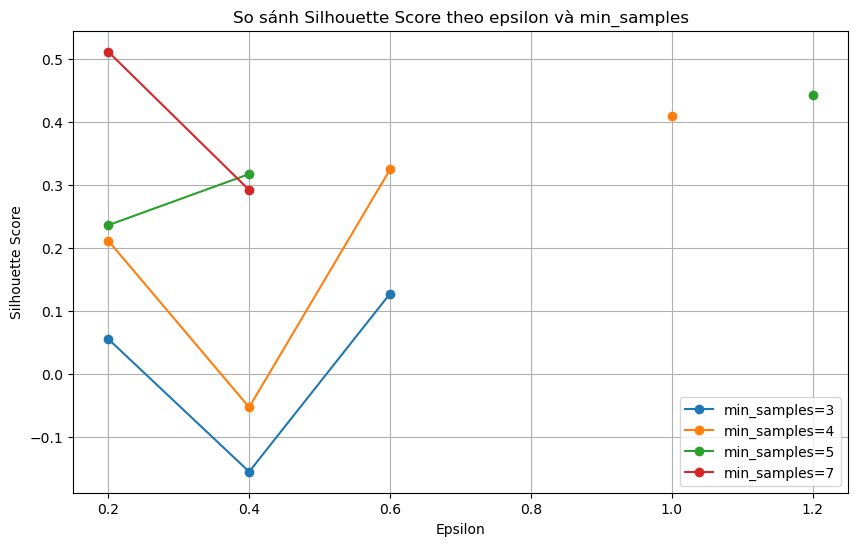

In [49]:
# Thêm cột silhouette_score vào DataFrame
silhouette_scores = []
for i, row in results_df.iterrows():
    labels = row['labels']
    mask = labels != -1
    valid_data = X_reduced[mask]
    valid_labels = labels[mask]

    if row['n_clusters'] > 1:
        sil = silhouette_score(valid_data, valid_labels)
    else:
        sil = np.nan

    silhouette_scores.append(sil)

results_df['silhouette_score'] = silhouette_scores

# Hiển thị kết quả
print(results_df[['epsilon', 'min_samples', 'n_clusters', 'n_noise', 'silhouette_score']])

# Tìm bộ tham số tốt nhất
best_idx = results_df['silhouette_score'].idxmax()
best = results_df.loc[best_idx]
print(f"\n🌟 Epsilon tối ưu: {best['epsilon']}, min_samples: {best['min_samples']}, Silhouette = {best['silhouette_score']:.3f}")

# ✅ Vẽ đồ thị Silhouette theo epsilon cho từng giá trị min_samples
plt.figure(figsize=(10,6))
for m in min_samples_values:
    subset = results_df[results_df['min_samples'] == m]
    plt.plot(subset['epsilon'], subset['silhouette_score'], marker='o', label=f"min_samples={m}")

plt.title('So sánh Silhouette Score theo epsilon và min_samples')
plt.xlabel('Epsilon')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.show()

### 7. Trực quan hóa kết quả phân cụm DBSCAN
Vì dữ liệu đã được giảm xuống 2 chiều,  
ta có thể vẽ trực tiếp kết quả phân cụm.  
Các điểm nhiễu được tô màu đen.


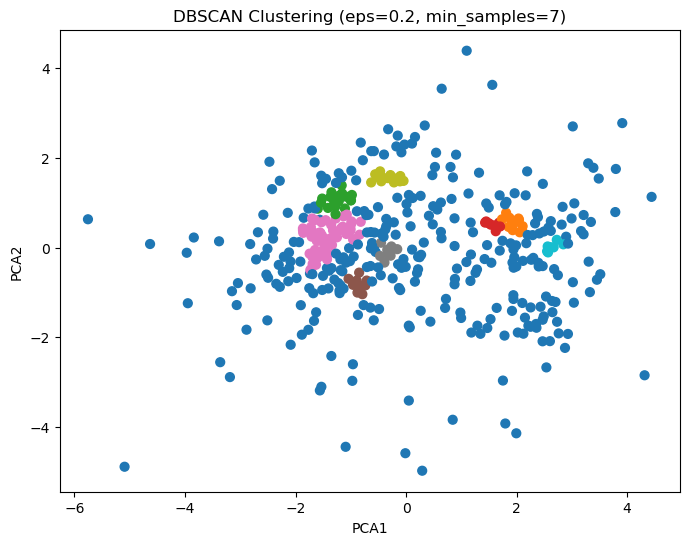

In [50]:
# Nếu dữ liệu X_reduced chưa phải PCA 2D thì giảm còn 2 thành phần để trực quan hóa
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X_reduced)

best_labels = best['labels']

plt.figure(figsize=(8,6))
plt.scatter(X_vis[:,0], X_vis[:,1], c=best_labels, cmap='tab10', s=40)
plt.title(f"DBSCAN Clustering (eps={best['epsilon']}, min_samples={best['min_samples']})")
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()


### 8. Kết luận
- Giảm chiều xuống 2D bằng PCA giúp DBSCAN hoạt động nhanh và dễ trực quan hóa hơn.  
- Số cụm tìm được phụ thuộc nhiều vào `eps` và `min_samples`.  
- Phương pháp này đặc biệt hữu ích khi dữ liệu chứa nhiễu hoặc mật độ không đồng đều.

> Gợi ý mở rộng:
> - Tự động chọn epsilon bằng KneeLocator.
> - So sánh với K-Means hoặc Hierarchical Clustering.
> - Áp dụng DBSCAN trên dữ liệu chưa giảm chiều để đối chiếu kết quả.
